# Working Title: Analysis of the Atlas of Rural and Small Town America dataset

## Goals:

### Scientific Analysis and Results
- Cites Sources
    - https://catalog.data.gov/dataset/atlas-of-rural-and-small-town-america
    - https://www.ers.usda.gov/data-products/atlas-of-rural-and-small-town-america/download-the-data/
    - https://www.kaggle.com/ananthu017/california-wildfire-incidents-20132020?select=California_Fire_Incidents.csv
    
 - Hypothesis driven
### Demonstration of Skills

#### Techinical Skills
- Python
- Jupyter notebook 
    - markdown
- data aquisition
    - find and load data
- descriptive data analysis
    - parametric vs non-parametric tests
    - numpy/ pandas
- data visualization
    - matplotlib
    - seaborn
- interpreting results

Soft Skills
- scientific communication

## Introduction

### Why wildfire? 

Global climate change is driving increases in fire occurence and intensity (source), while the increasing expansion of human settlements puts humans in more contact with wilderness areas prone to fire (source). Major Californian wildfires have garnered global news attention and caused X, Y, and Z dammage (source, source). Understanding the effects of wildfire on humans and economies on local/regional scales will aid in better planning for a future where risk of wildfire is higher. Here, I invesitgate the relationship between wildfire area and socioeconomic in rural counties in California during 20XX to 20XY.

### Hypotheses

Wildfires are devastating natural disasters that not only dirupt the lives and economies of the communities where they occur, but may also have significant post-fire effects that prevent a return to normalacy (which itself has cascading effects). Rural californian counties that experience higher wildfire occurrence may experience decreases in population and  employment rates following the event. I test the hypotheses that
1) 
2) 
3)

## Methods

### Data Sources

The Atlas of Rural and Small Town America (the atlas) provides socioeconomic data at the county level (source). 
    - https://catalog.data.gov/dataset/atlas-of-rural-and-small-town-america
    - https://www.ers.usda.gov/data-products/atlas-of-rural-and-small-town-america/download-the-data/

Description here
    - https://www.kaggle.com/ananthu017/california-wildfire-incidents-20132020?select=California_Fire_Incidents.csv

### Analysis 

Description here

## Analysis

### Prepare data

#### Import libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import csv
import math
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

#### Import datasets

In [2]:
# Import relevant datasets
jobs = pd.read_csv('jobs.csv', header = 0) # 
people = pd.read_csv('people.csv')
fires = pd.read_csv('California_Fire_Incidents.csv')

#### Prepare population estimates table

In [3]:
# Slice population data from people table
population = people[['State', 'County', 'TotalPopEst2010', 'TotalPopEst2011', 'TotalPopEst2012', 'TotalPopEst2013', 'TotalPopEst2014', 'TotalPopEst2015', 'TotalPopEst2016', 'TotalPopEst2017', 'TotalPopEst2018', 'TotalPopEst2019']]

# Select only counties in Clifornia. 
population = population[ population['State'] == 'CA']

# Remove State column and make County column new index
population = population.drop('State', 1)
population = population.set_index('County')

# Rename index and transpose so rows are years while columns are county names 
population.rename(index={'TotalPopEst2010': '2010',  'TotalPopEst2011': '2011', 'TotalPopEst2012': '2012', 'TotalPopEst2013': '2013', 'TotalPopEst2014': '2014', 'TotalPopEst2015': '2015', 'TotalPopEst2016': '2016', 'TotalPopEst2017': '2017', 'TotalPopEst2018': '2018', 'TotalPopEst2019': '2019'}, inplace=True)
population = population.transpose()
population

population.rename(index={'TotalPopEst2010': '2010', 'TotalPopEst2011': '2011', 'TotalPopEst2012': '2012', 'TotalPopEst2013': '2013', 'TotalPopEst2014': '2014', 'TotalPopEst2015': '2015', 'TotalPopEst2016': '2016', 'TotalPopEst2017': '2017', 'TotalPopEst2018': '2018', 'TotalPopEst2019': '2019'}, inplace=True)
# population

# Quick visualization of population trends for CA and each county
# population.plot(subplots = True, layout = (10,6), figsize=(30, 12));

#### Prepare employment statistic tables

In [4]:
# Select only counties in California.
jobs = jobs[jobs['State'] == 'CA']
#jobs.style

In [5]:
# Prepare tables for civilian labor force counts
# Slice employment data from jobs table.
nlabor = jobs[['State', 'County', 'NumCivLaborforce2007', 'NumCivLaborForce2008', 'NumCivLaborForce2009', 'NumCivLaborForce2010', 'NumCivLaborForce2011', 'NumCivLaborForce2012', 'NumCivLaborforce2013', 'NumCivLaborforce2014', 'NumCivLaborforce2015', 'NumCivLaborforce2016', 'NumCivLaborforce2017', 'NumCivLaborforce2018', 'NumCivLaborforce2019', 'NumCivLaborforce2020']]

# Remove State column and make County column new index
nlabor = nlabor.drop('State', 1)
nlabor = nlabor.set_index('County')

# Transpose so columns are names while rows are years                   
nlabor = nlabor.transpose()

# Rename indexes to years
nlabor.rename(index={'NumCivLaborforce2007': '2007', 'NumCivLaborForce2008': '2008', 'NumCivLaborForce2009': '2009', 'NumCivLaborForce2010': '2010', 'NumCivLaborForce2011': '2011', 'NumCivLaborForce2012': '2012', 'NumCivLaborforce2013': '2013', 'NumCivLaborforce2014': '2014', 'NumCivLaborforce2015': '2015', 'NumCivLaborforce2016': '2016', 'NumCivLaborforce2017': '2017', 'NumCivLaborforce2018': '2018', 'NumCivLaborforce2019': '2019', 'NumCivLaborforce2020': '2020'}, inplace=True)
#nlabor

In [6]:
# Repeat steps for the rest of the demographic tables

# Prepare table for number of employed per year
nemp = jobs[['State', 'County', 'NumEmployed2007', 'NumEmployed2008', 'NumEmployed2009', 'NumEmployed2010', 'NumEmployed2011', 'NumEmployed2012', 'NumEmployed2013', 'NumEmployed2014', 'NumEmployed2015', 'NumEmployed2016', 'NumEmployed2017', 'NumEmployed2018', 'NumEmployed2019', 'NumEmployed2020']] 
nemp = nemp.drop('State', 1)
nemp = nemp.set_index('County')
nemp = nemp.transpose()
nemp.rename(index={'NumEmployed2007': '2007', 'NumEmployed2008': '2008', 'NumEmployed2009': '2009', 'NumEmployed2010': '2010', 'NumEmployed2011': '2011', 'NumEmployed2012': '2012', 'NumEmployed2013': '2013', 'NumEmployed2014': '2014', 'NumEmployed2015': '2015', 'NumEmployed2016': '2016', 'NumEmployed2017': '2017', 'NumEmployed2018': '2018', 'NumEmployed2019': '2019', 'NumEmployed2020': '2020'}, inplace=True)
#nemp

# Prepare table for unemployment rate per year
runemp = jobs[['State', 'County', 'UnempRate2007', 'UnempRate2008', 'UnempRate2009', 'UnempRate2010', 'UnempRate2011', 'UnempRate2012', 'UnempRate2013', 'UnempRate2014', 'UnempRate2015', 'UnempRate2016', 'UnempRate2017', 'UnempRate2018', 'UnempRate2019', 'UnempRate2020']]
runemp = runemp.drop('State', 1)
runemp = runemp.set_index('County')
runemp = runemp.transpose()
runemp.rename(index={'UnempRate2007': '2007', 'UnempRate2008': '2008', 'UnempRate2009': '2009', 'UnempRate2010': '2010', 'UnempRate2011': '2011', 'UnempRate2012': '2012', 'UnempRate2013': '2013', 'UnempRate2014': '2014', 'UnempRate2015': '2015', 'UnempRate2016': '2016', 'UnempRate2017': '2017', 'UnempRate2018': '2018', 'UnempRate2019': '2019', 'UnempRate2020': '2020'}, inplace=True)
#runemp

# Prepare table number of unemployed per year
nunemp = jobs[['State', 'County', 'NumUnemployed2007', 'NumUnemployed2008', 'NumUnemployed2009', 'NumUnemployed2010', 'NumUnemployed2011', 'NumUnemployed2012', 'NumUnemployed2013', 'NumUnemployed2014', 'NumUnemployed2015', 'NumUnemployed2016', 'NumUnemployed2017', 'NumUnemployed2018', 'NumUnemployed2019', 'NumUnemployed2020']]
nunemp = nunemp.drop('State', 1)
nunemp = nunemp.set_index('County')
nunemp = nunemp.transpose()
nunemp.rename(index={'NumUnemployed2007': '2007', 'NumUnemployed2008': '2008', 'NumUnemployed2009': '2009', 'NumUnemployed2010': '2010', 'NumUnemployed2011': '2011', 'NumUnemployed2012': '2012', 'NumUnemployed2013': '2013', 'NumUnemployed2014': '2014', 'NumUnemployed2015': '2015', 'NumUnemployed2016': '2016', 'NumUnemployed2017': '2017', 'NumUnemployed2018': '2018', 'NumUnemployed2019': '2019', 'NumUnemployed2020': '2020'}, inplace=True)
#nunemp

#### Prepare wildfire dataset

In [7]:
# Drop rows for States of Oregon and Nevada, as well as Mexico
fires = fires[fires['Counties'] != 'State of Oregon'] 
fires = fires[fires['Counties'] != 'State of Nevada']
fires = fires[fires['Counties'] != 'Mexico']
fires = fires[fires['ArchiveYear'] < 2019] # so 2018 fires match next years' data (2019)

# Calculate acres burned per county per year and format
acres_burned = fires.groupby(["Counties", "ArchiveYear"])["AcresBurned"].sum().to_frame(name = 'AcresBurned')

# Reset indexes so dataframe is singly indexed
acres_burned = acres_burned.reset_index()
#acres_burned

#### Associate year-after employment statistics with yearly wildfire data

For each combination of County and Archive year in acres_burned (e.g. Yuba and 2017), 
add the employment metric value for that county and the year after the fire from the employment table in a new column in acres_burned.

In [8]:
# Number of civilians in labor force

# Catch values in list
tmp_labor = [] 

# Iterate over each row in acres_bruned
for index, row in acres_burned.iterrows():
    # Get the year after the fire
    yr = str(row[1] + 1)
    # Get the county
    cnty = str(row[0])
    # Temporary variable holds labor stat from that year/county combo
    tmp = nlabor.loc[yr, cnty]
    # Add temporary variable to list
    tmp_labor.append(tmp)

# Set list as new column in acres burned
acres_burned['nlabor_yaf'] = tmp_labor

In [9]:
# Repeat steps for the rest of the demographic tables

# Number of employed people
tmp_labor = [] 
for index, row in acres_burned.iterrows():
    yr = str(row[1] + 1)
    cnty = str(row[0])
    tmp = nemp.loc[yr, cnty]
    tmp_labor.append(tmp)
acres_burned['nemp_yaf'] = tmp_labor

# Rate of unmeployment
tmp_labor = [] 
for index, row in acres_burned.iterrows():
    yr = str(row[1] + 1)
    cnty = str(row[0])
    tmp = runemp.loc[yr, cnty]
    tmp_labor.append(tmp)
acres_burned['runemp_yaf'] = tmp_labor

# Number of unemployed people
tmp_labor = [] 
for index, row in acres_burned.iterrows():
    yr = str(row[1] + 1)
    cnty = str(row[0])
    tmp = nunemp.loc[yr, cnty]
    tmp_labor.append(tmp)
acres_burned['nunemp_yaf'] = tmp_labor

# Population 
tmp1_pop = []
tmp2_pop = []
tmp3_pop = []

for index, row in acres_burned.iterrows():
    yaf = str(row[1] + 1)
    yr = str(row[1])
    cnty = str(row[0])
    tmp1 = population.loc[yaf, cnty]
    tmp1_pop.append(tmp1)
    tmp2 = population.loc[yaf, cnty] - population.loc[yr, cnty]
    tmp2_pop.append(tmp2)
    tmp3 = population.loc[yr, cnty]
    tmp3_pop.append(tmp3)
acres_burned['pop_yf'] = tmp3_pop # Population the year of the fire
acres_burned['pop_yaf'] = tmp1_pop # Population the year after the fire
acres_burned['deltapop_yaf'] = tmp2_pop # Change in population between the year after the fire and the year of the fire.

#acres_burned

#### Test for normality

Visual inspection of the diagonal histograms indicates none of the numeric data are normally distributed.

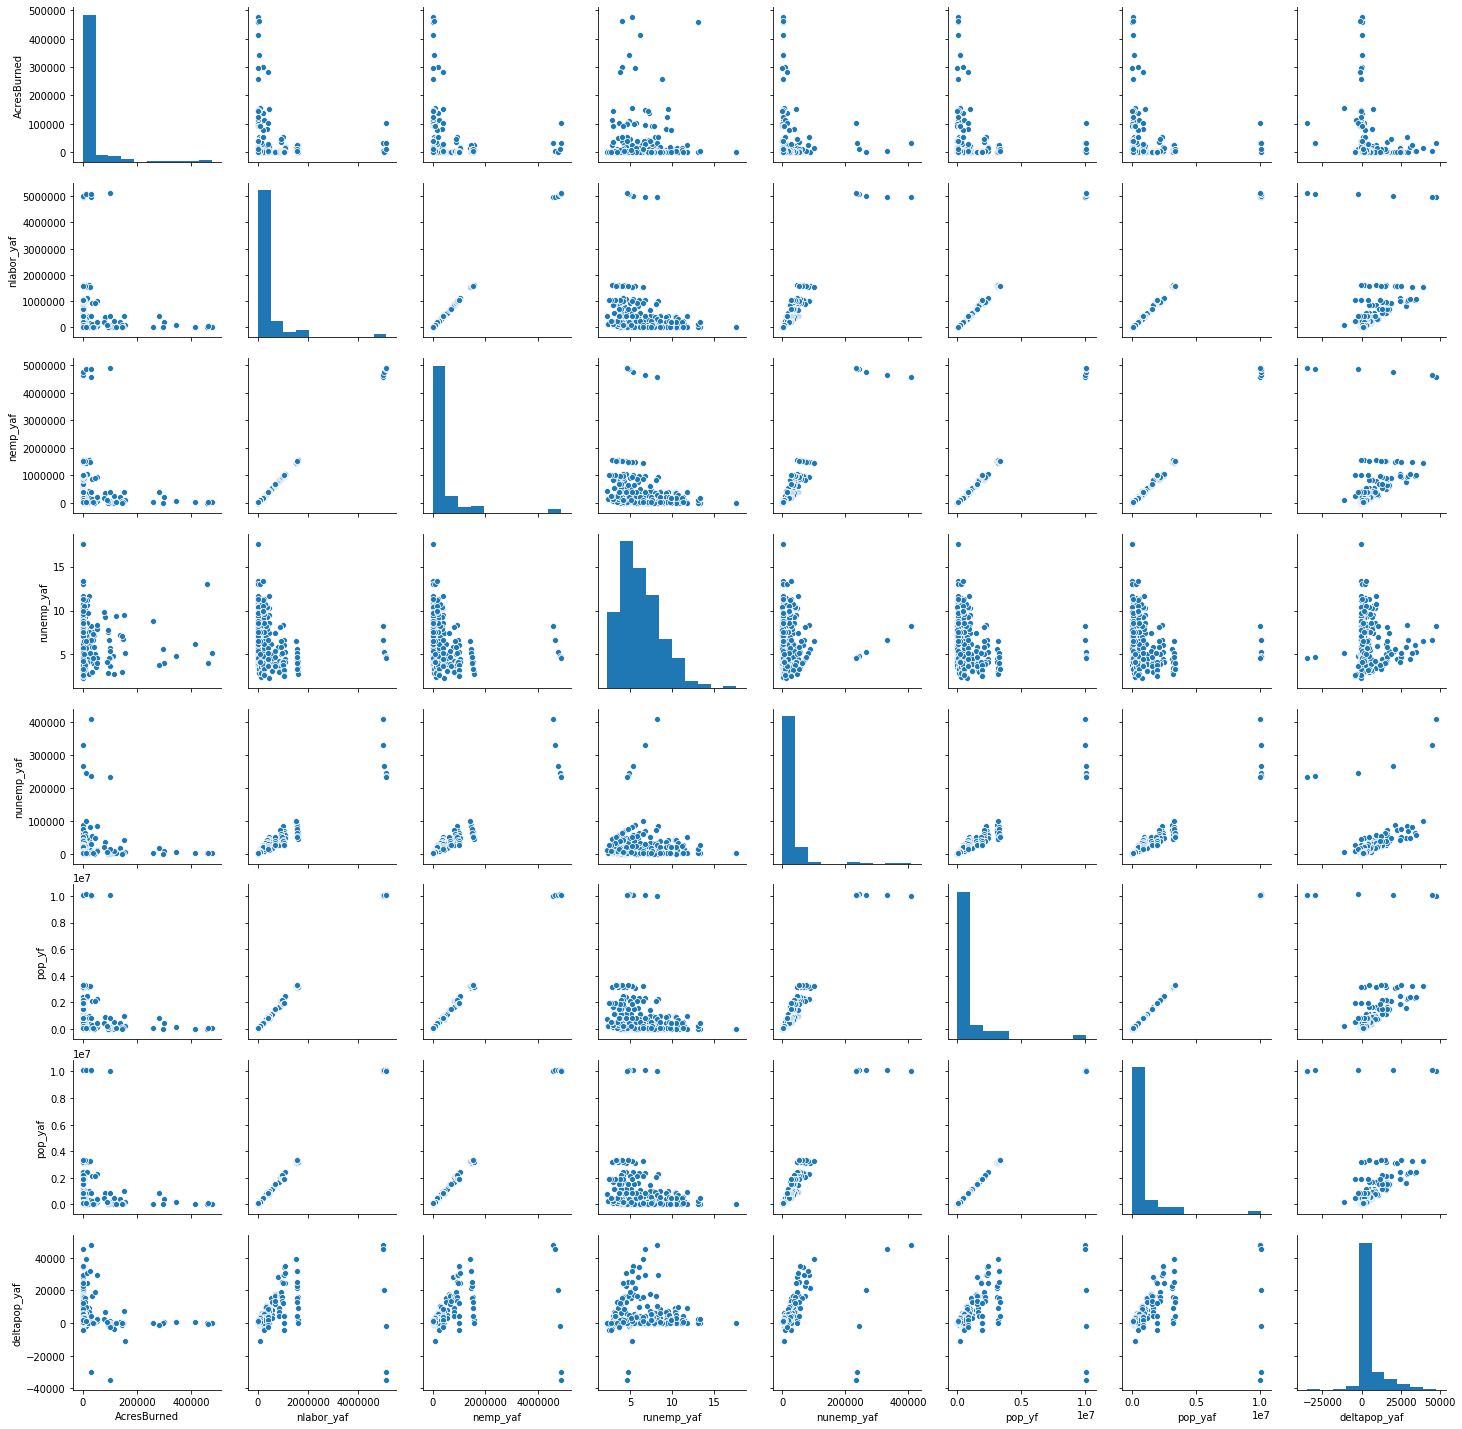

In [20]:
burn_data = acres_burned[['AcresBurned', 'nlabor_yaf', 'nemp_yaf', 'runemp_yaf', 'nunemp_yaf', 'pop_yf', 'pop_yaf', 'deltapop_yaf']]
sns.pairplot(burn_data)

Shapiro-Wilkes test for normality also indicate none of the data are normally distributed.

In [11]:
variable = []
pval = []
shapiro_W = []
for name, values in burn_data.iteritems():
    variable.append(name)
    res = stats.shapiro(values)
    shapiro_W.append(res[0])
    pval.append(res[1])

norm_res = {'variable': variable, 'p-value': pval, 'W-score': shapiro_W}
shapiro_normality = pd.DataFrame(data = norm_res)
shapiro_normality 

,variable,p-value,W-score
0,AcresBurned,2.565798e-29,0.401828
1,nlabor_yaf,3.281607e-28,0.457505
2,nemp_yaf,3.671113e-28,0.459857
3,runemp_yaf,1.307983e-08,0.945766
4,nunemp_yaf,6.990636e-29,0.424239
5,pop_yf,5.773771e-28,0.469273
6,pop_yaf,6.316442e-28,0.471125
7,deltapop_yaf,9.652995e-23,0.676039


Apply a log transform to the data

In [18]:
burn_data1 = acres_burned[['AcresBurned', 'nlabor_yaf', 'nemp_yaf', 'runemp_yaf', 'nunemp_yaf', 'pop_yf', 'pop_yaf', 'deltapop_yaf']]

for name, values in burn_data.iteritems():
    namea = name + '_log'
    vals = []
    for i in values:
        if i > 0:
            vals.append(math.log(i))
        else:
            vals.append(np.NaN)
    burn_data1[namea] = vals
    
burn_data = burn_data1[['AcresBurned', 'nlabor_yaf', 'nemp_yaf', 'runemp_yaf', 'nunemp_yaf', 'pop_yf', 'pop_yaf', 'deltapop_yaf']]
    
burn_data_log = burn_data1[['AcresBurned_log', 'nlabor_yaf_log', 'nemp_yaf_log', 'runemp_yaf_log', 'nunemp_yaf_log', 'pop_yf_log', 'pop_yaf_log', 'deltapop_yaf_log']]
#burn_data_log

C:\Users\15414\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,AcresBurned_log,nlabor_yaf_log,nemp_yaf_log,runemp_yaf_log,nunemp_yaf_log,pop_yf_log,pop_yaf_log,deltapop_yaf_log
0,6.169611,13.600243,13.539519,1.774952,10.768632,14.272678,14.290372,10.247042
1,8.113726,13.631380,13.587401,1.458615,10.485424,14.306871,14.316861,9.705768
2,5.351858,13.639605,13.601887,1.308333,10.343193,14.316861,14.322446,9.131946
3,6.285998,13.642922,13.611790,1.131402,10.157897,14.322446,14.326390,8.788746
4,7.160846,13.642436,13.612034,1.098612,10.134044,14.326390,14.329130,8.427925
5,NaN,6.317165,6.249975,1.871802,3.583519,6.981935,6.953684,NaN
6,NaN,6.308098,6.244167,1.824549,3.526361,6.953684,7.013016,4.158883
7,4.564348,9.569482,9.481741,2.128232,7.092574,10.508350,10.511240,4.663439
8,8.352319,9.569203,9.500469,1.887070,6.857514,10.511240,10.519511,5.720312
9,6.028279,9.583627,9.522081,1.791759,6.765039,10.519511,10.530201,5.986452


Shapiro-Wilkes test for normality of log transformed data are normally distributed- except for runemp_yaf_log.

In [24]:
variable = []
pval = []
shapiro_W = []
for name, values in burn_data_log.iteritems():
    variable.append(name)
    vals = values[np.logical_not(np.isnan(values))]    
    res = stats.shapiro(vals)
    shapiro_W.append(res[0])
    pval.append(res[1])

norm_res = {'variable': variable, 'p-value': pval, 'W-score': shapiro_W}
shapiro_normality_log = pd.DataFrame(data = norm_res)
shapiro_normality_log

,variable,p-value,W-score
0,AcresBurned_log,0.003295,0.983791
1,nlabor_yaf_log,0.016044,0.987445
2,nemp_yaf_log,0.018812,0.987786
3,runemp_yaf_log,0.575351,0.995371
4,nunemp_yaf_log,0.023119,0.988226
5,pop_yf_log,0.019946,0.987911
6,pop_yaf_log,0.020526,0.987972
7,deltapop_yaf_log,0.003413,0.979425


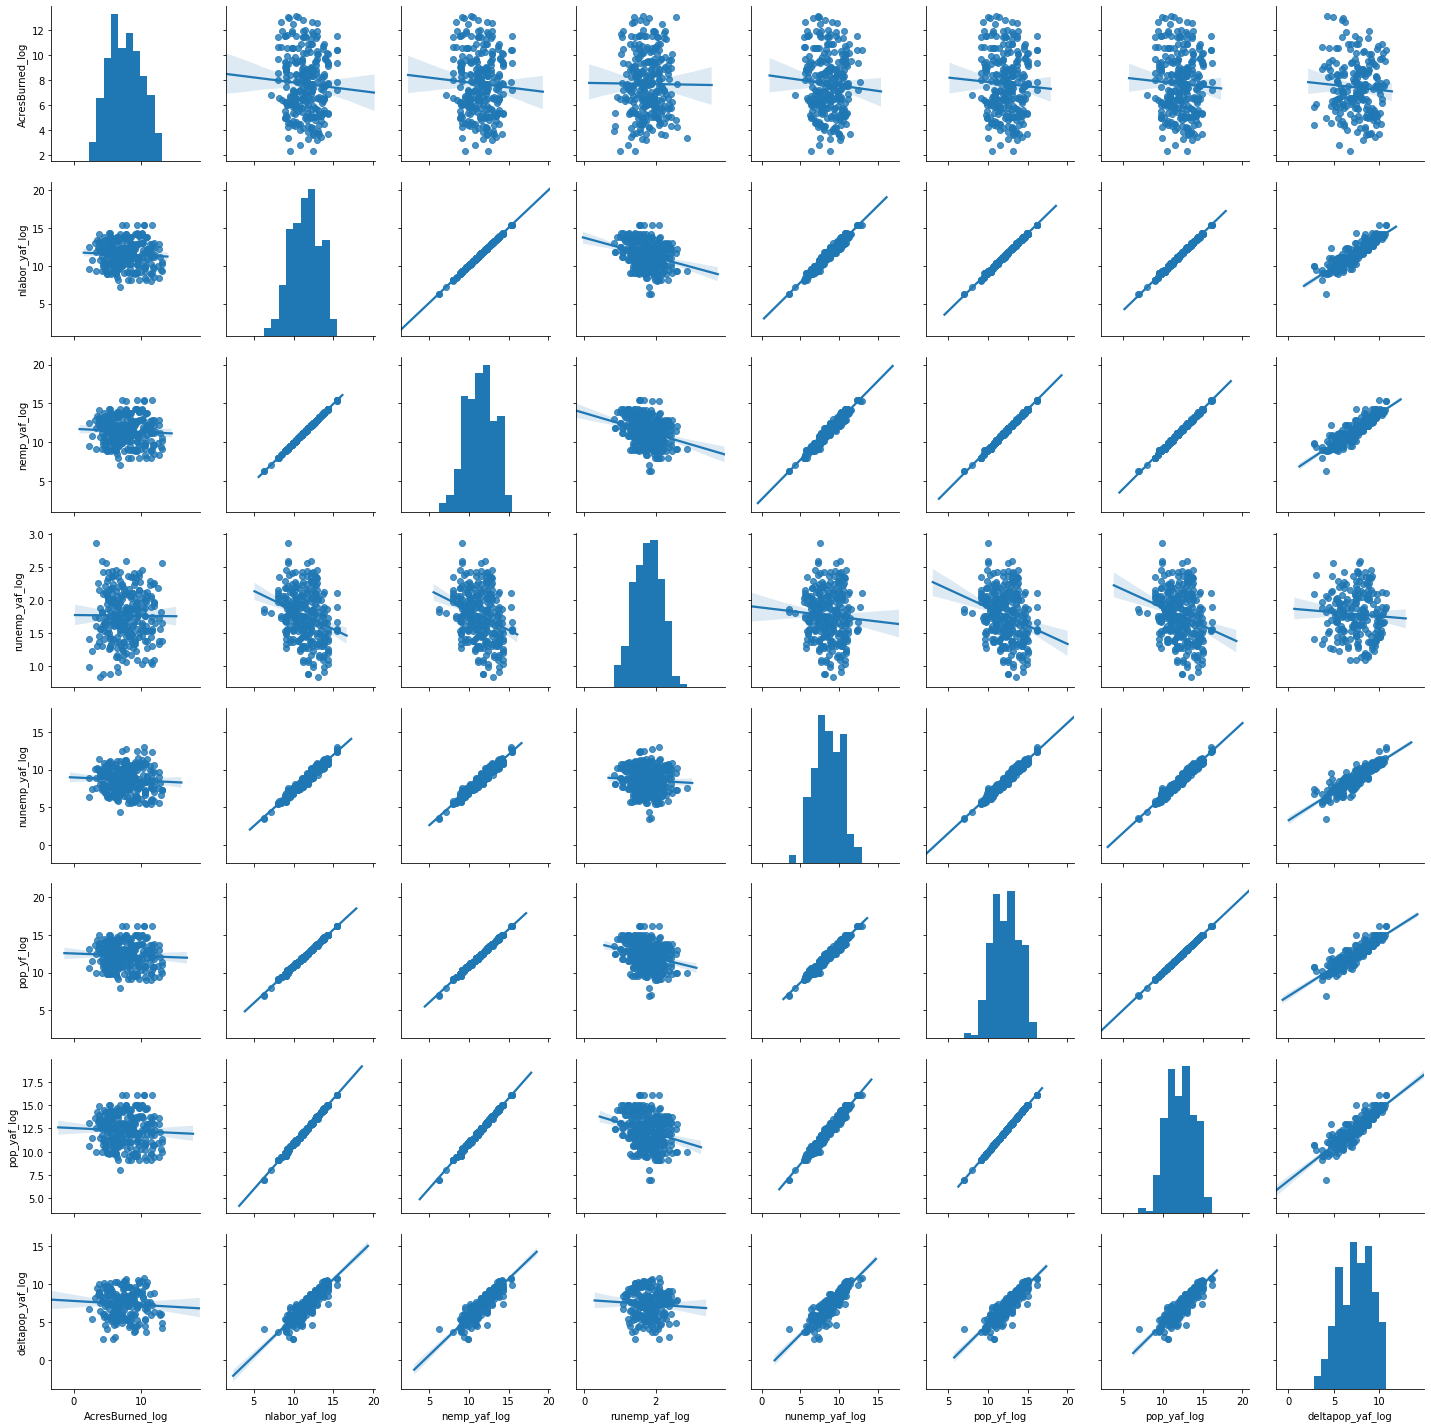

In [27]:
sns.pairplot(burn_data_log, kind = 'reg')

In [ ]:
plt.scatter(acres_burned['AcresBurned'], acres_burned['nlabor_yaf'], label='Civilian Labor Force (n)')
plt.scatter(acres_burned['AcresBurned'], acres_burned['nemp_yaf'], label='Employed (n)')
plt.scatter(acres_burned['AcresBurned'], acres_burned['nunemp_yaf'], label='Unemployed (n)')

In [ ]:
plt.scatter(acres_burned['AcresBurned'], acres_burned['pop_yaf'], label='Population')

In [ ]:
plt.scatter(acres_burned['AcresBurned'], acres_burned['runemp_yaf'], label='Unemployment Rate')

In [ ]:
plt.scatter(acres_burned['AcresBurned'], acres_burned['deltapop_yaf'], label='Change in Population')